In [ ]:
import warnings

import matplotlib.pyplot as plt
import pandas as pd
import pmdarima as pmd
from prophet import Prophet
import statsmodels as sm
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller, kpss

warnings.filterwarnings('ignore')

## Modelování časových řad počtu nově nakažených nemocí COVID-19 v ČR

V tomto notebooku budeme modelovat data nově nakažených nemocí COVID-19 v ČR. Nejprve vyzkoušíme nasadit SARIMA model a poté vyzkoušíme možnosti modelování pomocí balíčku `Prophet`.

* Data jsou dostupná zde: https://github.com/owid/covid-19-data/tree/master/public/data

### Data

In [163]:
df = pd.read_csv('data\owid-covid-data.csv')
df.head()

,iso_code,continent,location,date,total_cases,new_cases,new_cases_smoothed,total_deaths,new_deaths,new_deaths_smoothed,...,male_smokers,handwashing_facilities,hospital_beds_per_thousand,life_expectancy,human_development_index,population,excess_mortality_cumulative_absolute,excess_mortality_cumulative,excess_mortality,excess_mortality_cumulative_per_million
0,AFG,Asia,Afghanistan,2020-02-24,5.0,5.0,NaN,NaN,NaN,NaN,...,NaN,37.746,0.5,64.83,0.511,41128772.0,NaN,NaN,NaN,NaN
1,AFG,Asia,Afghanistan,2020-02-25,5.0,0.0,NaN,NaN,NaN,NaN,...,NaN,37.746,0.5,64.83,0.511,41128772.0,NaN,NaN,NaN,NaN
2,AFG,Asia,Afghanistan,2020-02-26,5.0,0.0,NaN,NaN,NaN,NaN,...,NaN,37.746,0.5,64.83,0.511,41128772.0,NaN,NaN,NaN,NaN
3,AFG,Asia,Afghanistan,2020-02-27,5.0,0.0,NaN,NaN,NaN,NaN,...,NaN,37.746,0.5,64.83,0.511,41128772.0,NaN,NaN,NaN,NaN
4,AFG,Asia,Afghanistan,2020-02-28,5.0,0.0,NaN,NaN,NaN,NaN,...,NaN,37.746,0.5,64.83,0.511,41128772.0,NaN,NaN,NaN,NaN


Zajímá nás pouze sloupec `new_cases`

In [164]:
df.columns

Index(['iso_code', 'continent', 'location', 'date', 'total_cases', 'new_cases',
       'new_cases_smoothed', 'total_deaths', 'new_deaths',
       'new_deaths_smoothed', 'total_cases_per_million',
       'new_cases_per_million', 'new_cases_smoothed_per_million',
       'total_deaths_per_million', 'new_deaths_per_million',
       'new_deaths_smoothed_per_million', 'reproduction_rate', 'icu_patients',
       'icu_patients_per_million', 'hosp_patients',
       'hosp_patients_per_million', 'weekly_icu_admissions',
       'weekly_icu_admissions_per_million', 'weekly_hosp_admissions',
       'weekly_hosp_admissions_per_million', 'total_tests', 'new_tests',
       'total_tests_per_thousand', 'new_tests_per_thousand',
       'new_tests_smoothed', 'new_tests_smoothed_per_thousand',
       'positive_rate', 'tests_per_case', 'tests_units', 'total_vaccinations',
       'people_vaccinated', 'people_fully_vaccinated', 'total_boosters',
       'new_vaccinations', 'new_vaccinations_smoothed',
       't

`iso_code` pro Českou republiku je `CZE`

In [165]:
df['iso_code'].unique()

array(['AFG', 'OWID_AFR', 'ALB', 'DZA', 'AND', 'AGO', 'AIA', 'ATG', 'ARG',
       'ARM', 'ABW', 'OWID_ASI', 'AUS', 'AUT', 'AZE', 'BHS', 'BHR', 'BGD',
       'BRB', 'BLR', 'BEL', 'BLZ', 'BEN', 'BMU', 'BTN', 'BOL', 'BES',
       'BIH', 'BWA', 'BRA', 'VGB', 'BRN', 'BGR', 'BFA', 'BDI', 'KHM',
       'CMR', 'CAN', 'CPV', 'CYM', 'CAF', 'TCD', 'CHL', 'CHN', 'COL',
       'COM', 'COG', 'COK', 'CRI', 'CIV', 'HRV', 'CUB', 'CUW', 'CYP',
       'CZE', 'COD', 'DNK', 'DJI', 'DMA', 'DOM', 'ECU', 'EGY', 'SLV',
       'OWID_ENG', 'GNQ', 'ERI', 'EST', 'SWZ', 'ETH', 'OWID_EUR',
       'OWID_EUN', 'FRO', 'FLK', 'FJI', 'FIN', 'FRA', 'PYF', 'GAB', 'GMB',
       'GEO', 'DEU', 'GHA', 'GIB', 'GRC', 'GRL', 'GRD', 'GUM', 'GTM',
       'GGY', 'GIN', 'GNB', 'GUY', 'HTI', 'OWID_HIC', 'HND', 'HKG', 'HUN',
       'ISL', 'IND', 'IDN', 'OWID_INT', 'IRN', 'IRQ', 'IRL', 'IMN', 'ISR',
       'ITA', 'JAM', 'JPN', 'JEY', 'JOR', 'KAZ', 'KEN', 'KIR', 'OWID_KOS',
       'KWT', 'KGZ', 'LAO', 'LVA', 'LBN', 'LSO', 'LBR', 'LBY', '

Sloupce přejmenujeme na `ds` a `y`, kvůli kompatibilitě s balíčkem `Prophet`.

In [166]:
df_cze = (
    df[
        df['iso_code']=='CZE'
    ]
    [['date', 'new_cases']]
    .reset_index(drop=True)
    .rename(columns={'date':'ds', 'new_cases':'y'})
    .astype({'ds':'datetime64'})
)

### Modelování

#### Předzpracování dat

Snažit se modelovat na celé historii dat by nepřineslo žádné zlepšení, šíření nemoci je ovlivněno hodně faktory, které se mění v čase, např. různá opatření, atd., proto se nejprve omezíme na posledních 90 dní. Postupně se zkusíme omezit na ještě kratší historii. Zároveň nebudeme predikovat na víc než několik dní dopředu.

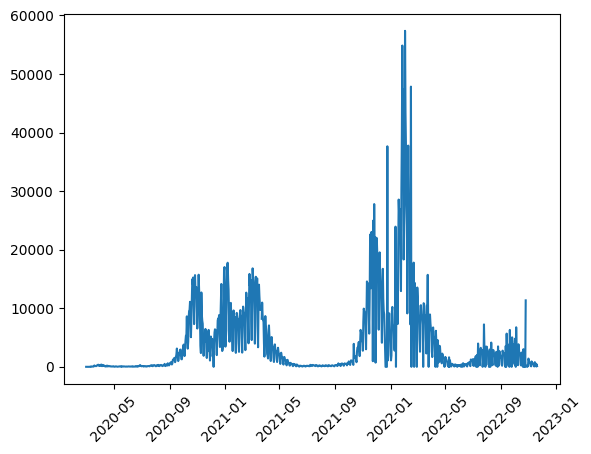

In [7]:
plt.plot(df_cze['ds'], df_cze['y'])
plt.xticks(rotation=45)
plt.show()

V posledních 90 dnech lze pozorovat, že ke konci řijná nám pro jeden den chybí data.

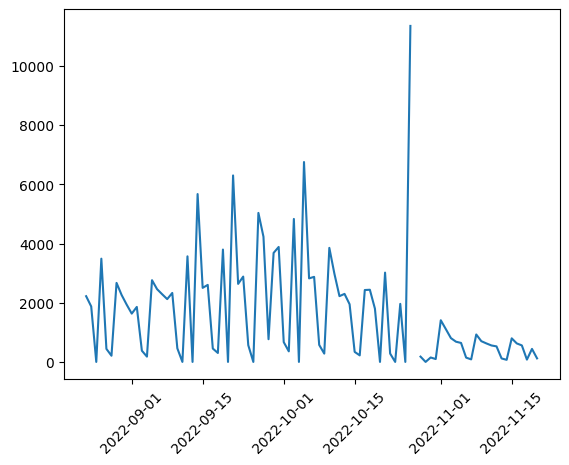

In [8]:
df_cze_3m = df_cze.tail(90)
plt.plot(df_cze_3m['ds'], df_cze_3m['y'])
plt.xticks(rotation=45)
plt.show()

Za chybějící data doplníme průměr z prvních sousedních nechybějících dat.

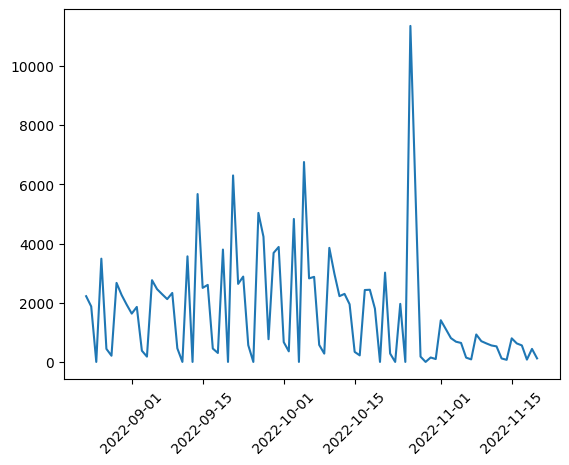

In [9]:
df_cze_3m.loc[:,'y'] = df_cze_3m['y'].ffill().add(df_cze_3m['y'].bfill()).div(2)
plt.plot(df_cze_3m['ds'], df_cze_3m['y'])
plt.xticks(rotation=45)
plt.show()

#### SARIMA

In [10]:
def acf_pacf(y, lags):
    fig = plt.Figure(figsize=(14,6))
    ax1 = plt.subplot2grid((1,2), (0, 0))
    ax2 = plt.subplot2grid((1,2), (0, 1))
    plot_acf(y, lags=lags, ax=ax1)
    plot_pacf(y, lags=lags, ax=ax2, method='ywm')
    plt.show()

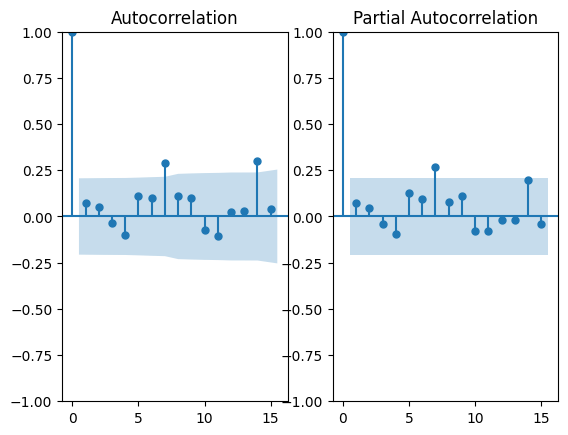

In [11]:
acf_pacf(df_cze_3m['y'], 15)

Z ACF a PACF vidíme 7-denní sezónnost, která se dala předpokládat. Pomocí následujících testů otestujeme, zda je potřeba differencovat, kvůli jednotkovému kořenu, nebo zda je časová řada stacionární.

In [12]:
adfuller(df_cze_3m['y'], autolag='AIC', maxlag=10)

(-8.647758107650432,
 5.2145413155285846e-14,
 0,
 89,
 {'1%': -3.506057133647011,
  '5%': -2.8946066061911946,
  '10%': -2.5844100201994697},
 1429.6633645337197)

Dle Dickey Fuller testu zamítáme nulovou hypotézu, tedy jednotkový kořen není přítomen.

In [13]:
kpss(df_cze_3m['y'], regression='ct', nlags="auto")

(0.20116296115691015,
 0.015563889566158692,
 1,
 {'10%': 0.119, '5%': 0.146, '2.5%': 0.176, '1%': 0.216})

Dle KPSS testu zamítáme nulovou hypotézu ve prospěch alternativní, tedy že řada není stacionární.

Víme, že řada není stacionární a neobsahuje jednotkový kořen. Může se zdát, že si tyto testy protiřečí.

Zkusíme tedy diferencovat jak normálně, tak sezónně.


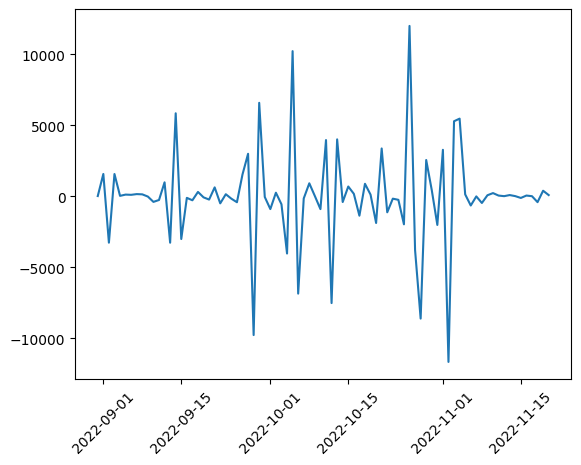

In [32]:
plt.plot(df_cze_3m['ds'], df_cze_3m['y'].diff().diff(7))
plt.xticks(rotation=45)
plt.show()

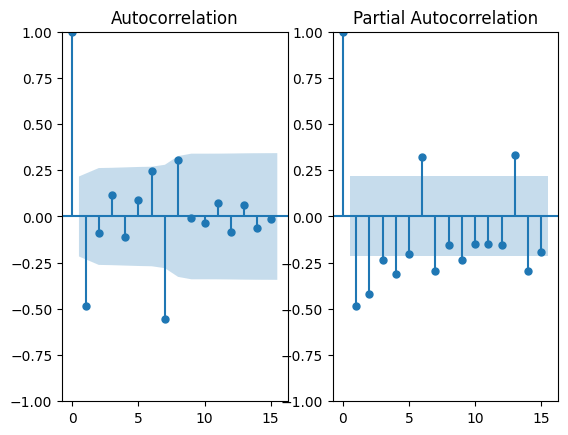

In [42]:
acf_pacf(df_cze_3m['y'].diff().diff(7).dropna(), 15)

In [34]:
adfuller(df_cze_3m['y'].diff().diff(7).dropna(), autolag='AIC', maxlag=10)

(-5.075580923379868,
 1.5693693899135176e-05,
 8,
 73,
 {'1%': -3.5232835753964475,
  '5%': -2.902030597326081,
  '10%': -2.5883710883843123},
 1318.1823602829168)

In [36]:
kpss(df_cze_3m['y'].diff().diff(7).dropna(), regression='c', nlags="auto")

(0.12736685112523338,
 0.1,
 21,
 {'10%': 0.347, '5%': 0.463, '2.5%': 0.574, '1%': 0.739})

Můžeme pozorovat zlepšení v KPSS testu, tedy že pomocí diferencování jsme se přiblížili ke stacionaritě.

Podle ACF a PACF zvolíme první model jako sezónní model SARIMA(2,1,0)7 a zároveň ARIMA(0,1,1).

In [64]:
model = sm.tsa.arima.model.ARIMA(df_cze_3m['y'], order=(0, 1, 1), seasonal_order=(2,1,0,7))
res = model.fit()
print(res.summary())

                                    SARIMAX Results                                     
Dep. Variable:                                y   No. Observations:                   90
Model:             ARIMA(0, 1, 1)x(2, 1, [], 7)   Log Likelihood                -730.965
Date:                          Mon, 21 Nov 2022   AIC                           1469.931
Time:                                  11:55:08   BIC                           1479.557
Sample:                                       0   HQIC                          1473.796
                                           - 90                                         
Covariance Type:                            opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.9196      0.060    -15.256      0.000      -1.038      -0.801
ar.S.L7       -0.7855      0.068    -11.515      0.

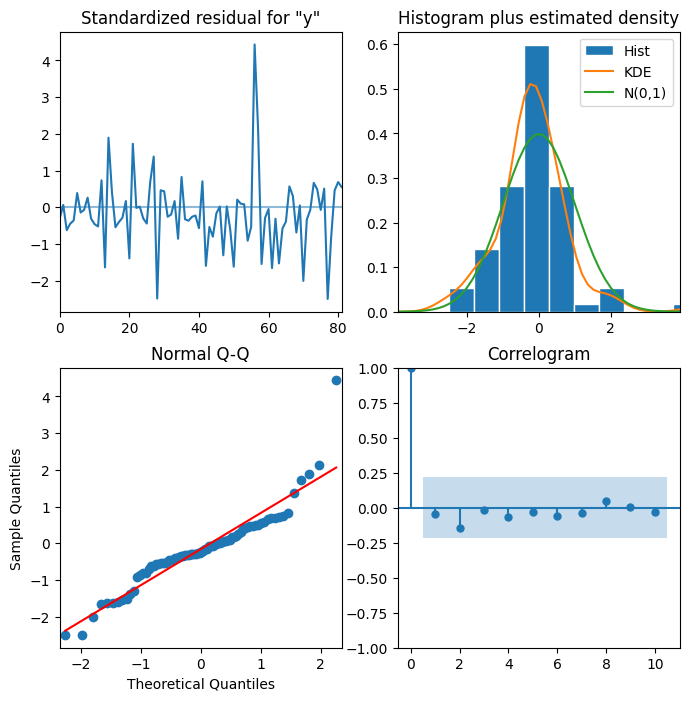

In [65]:
res.plot_diagnostics(figsize=(8,8))
plt.show()

Testové statistiky a p-hodnoty vypadají slibně, zkusíme nafitovat parametry pomocí balíčku `pmdarima`.

In [68]:
stepwise_fit = pmd.auto_arima(
    df_cze_3m['y'],
    start_p=0, start_q=0,
    max_p=3, max_q=3, m=7, d=1, D=1,
    start_P=0, max_P=2, start_Q=0, max_Q=2,
    information_criterion='bic', trace=True,
    seasonal=True, n_jobs=1, stepwise=True
)

Performing stepwise search to minimize bic
 ARIMA(0,1,0)(0,1,0)[7]             : BIC=1571.009, Time=0.04 sec
 ARIMA(1,1,0)(1,1,0)[7]             : BIC=1529.082, Time=0.66 sec
 ARIMA(0,1,1)(0,1,1)[7]             : BIC=inf, Time=0.58 sec
 ARIMA(1,1,0)(0,1,0)[7]             : BIC=1553.807, Time=0.10 sec
 ARIMA(1,1,0)(2,1,0)[7]             : BIC=1510.031, Time=0.92 sec
 ARIMA(1,1,0)(2,1,1)[7]             : BIC=1513.320, Time=1.71 sec
 ARIMA(1,1,0)(1,1,1)[7]             : BIC=inf, Time=0.58 sec
 ARIMA(0,1,0)(2,1,0)[7]             : BIC=1524.121, Time=0.45 sec
 ARIMA(2,1,0)(2,1,0)[7]             : BIC=1500.800, Time=0.75 sec
 ARIMA(2,1,0)(1,1,0)[7]             : BIC=1518.423, Time=0.43 sec
 ARIMA(2,1,0)(2,1,1)[7]             : BIC=1504.217, Time=1.25 sec
 ARIMA(2,1,0)(1,1,1)[7]             : BIC=inf, Time=0.97 sec
 ARIMA(3,1,0)(2,1,0)[7]             : BIC=1500.769, Time=0.94 sec
 ARIMA(3,1,0)(1,1,0)[7]             : BIC=1518.137, Time=0.52 sec
 ARIMA(3,1,0)(2,1,1)[7]             : BIC=1504.6

`pmdarima` našla stejný model, zkusíme s ním predikovat hodnoty následujících dnů.

In [69]:
model = sm.tsa.arima.model.ARIMA(df_cze_3m['y'], order=(0, 1, 1), seasonal_order=(2,1,0,7))
res = model.fit()
print(res.summary())

                                    SARIMAX Results                                     
Dep. Variable:                                y   No. Observations:                   90
Model:             ARIMA(0, 1, 1)x(2, 1, [], 7)   Log Likelihood                -730.965
Date:                          Mon, 21 Nov 2022   AIC                           1469.931
Time:                                  12:13:51   BIC                           1479.557
Sample:                                       0   HQIC                          1473.796
                                           - 90                                         
Covariance Type:                            opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.9196      0.060    -15.256      0.000      -1.038      -0.801
ar.S.L7       -0.7855      0.068    -11.515      0.

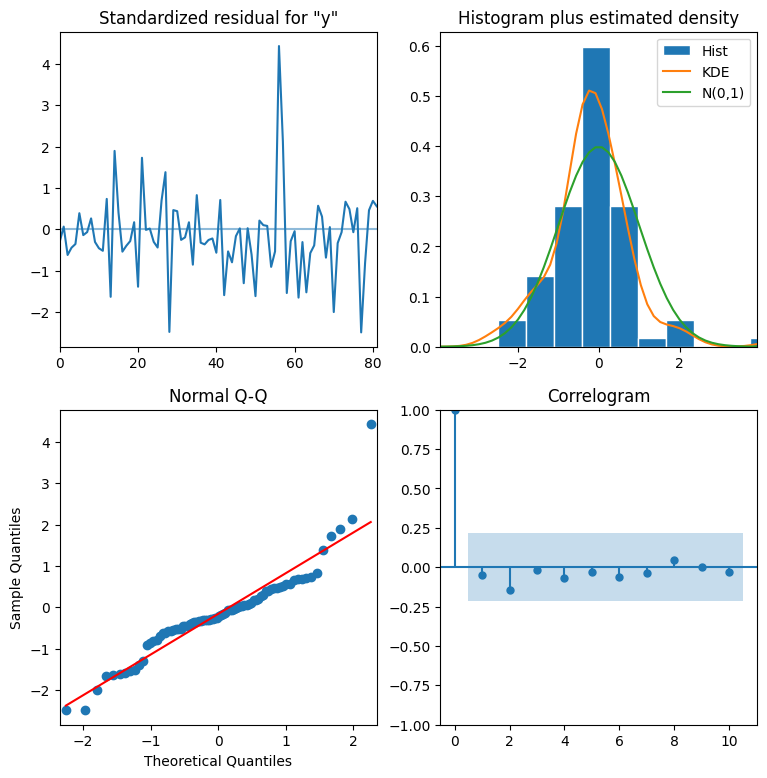

In [70]:
res.plot_diagnostics(figsize=(9,9))
plt.show()

Na konec zkusíme predikovat až 7 dní pomocí tohoto modelu.

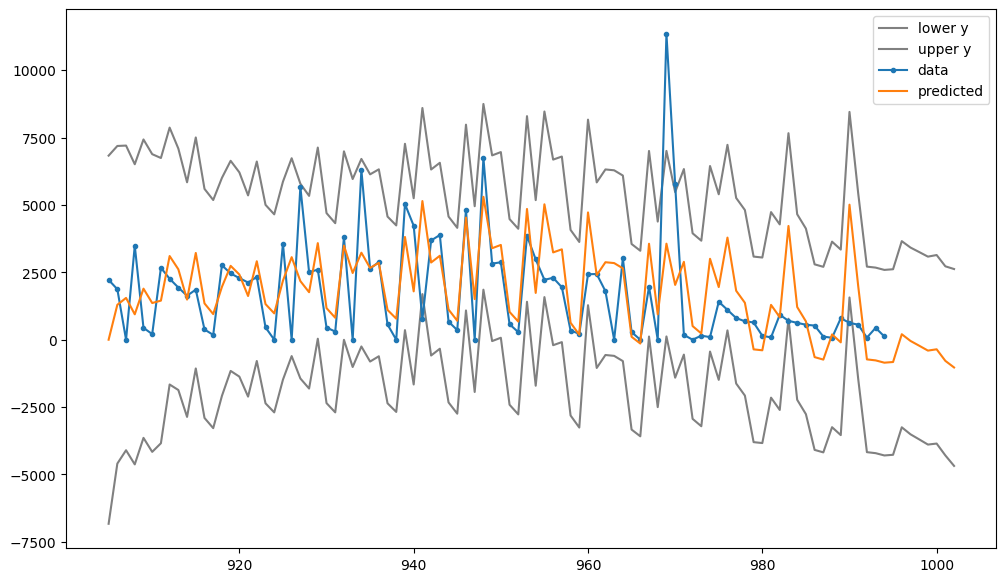

In [71]:
days_to_pred = 7
preds = res.get_prediction(end=len(df_cze_3m)+days_to_pred)
ci = preds.conf_int()

fig = ci.plot(color='grey', figsize=(12, 7))
res.data.orig_endog.plot(label='data', marker='.', fig=fig)
preds.predicted_mean.plot(label='predicted', fig=fig)
plt.legend()
plt.show()

Jak lze pozorovat model nedokáže odchytit náhlé změny v řádech incidencí nákazy. Zkusíme tedy proces zopakovat pro kratší historii dat, kde vynecháme obrovský peak ke konci října. Což je posledních 24 dní.

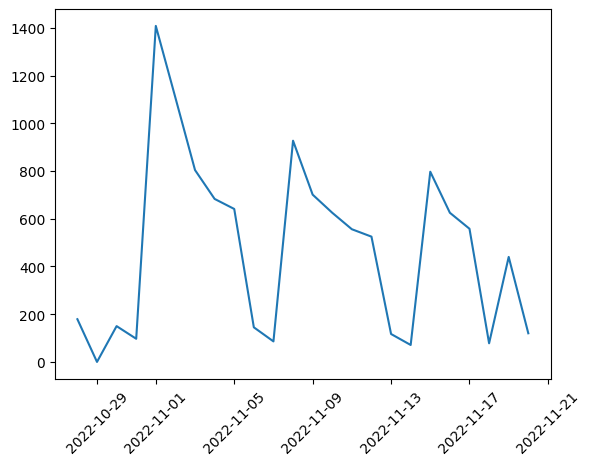

In [95]:
df_cze_24d = df_cze.tail(24)
plt.plot(df_cze_24d['ds'], df_cze_24d['y'])
plt.xticks(rotation=45)
plt.show()

In [114]:
adfuller(df_cze_24d['y'], autolag='AIC')

(0.24973930131459782,
 0.9749173334358386,
 6,
 17,
 {'1%': -3.889265672705068,
  '5%': -3.0543579727254224,
  '10%': -2.66698384083045},
 183.58985774527943)

In [115]:

kpss(df_cze_24d['y'], regression='c', nlags="auto")

(0.11025722921054305,
 0.1,
 1,
 {'10%': 0.347, '5%': 0.463, '2.5%': 0.574, '1%': 0.739})

Dle testů by měla být časová řada trend stacionární, tedy je potřeba detrendovat. Opět pomocí normalního i sezónního diferencování.

In [116]:
stepwise_fit = pmd.auto_arima(
    df_cze_24d['y'],
    start_p=0, start_q=0,
    max_p=2, max_q=2, m=7, d=1, D=1,
    start_P=0, max_P=2, start_Q=0, max_Q=2,
    information_criterion='bic', trace=True,
    seasonal=True, n_jobs=1, stepwise=False
)

 ARIMA(0,1,0)(0,1,0)[7]             : BIC=225.982, Time=0.07 sec
 ARIMA(0,1,0)(0,1,1)[7]             : BIC=228.649, Time=0.28 sec
 ARIMA(0,1,0)(0,1,2)[7]             : BIC=231.419, Time=0.86 sec
 ARIMA(0,1,0)(1,1,0)[7]             : BIC=228.654, Time=0.31 sec
 ARIMA(0,1,0)(1,1,1)[7]             : BIC=231.419, Time=0.76 sec
 ARIMA(0,1,0)(1,1,2)[7]             : BIC=234.192, Time=0.62 sec
 ARIMA(0,1,0)(2,1,0)[7]             : BIC=7101689775.092, Time=0.42 sec
 ARIMA(0,1,0)(2,1,1)[7]             : BIC=234.191, Time=0.65 sec
 ARIMA(0,1,0)(2,1,2)[7]             : BIC=inf, Time=1.08 sec
 ARIMA(0,1,1)(0,1,0)[7]             : BIC=228.180, Time=0.18 sec
 ARIMA(0,1,1)(0,1,1)[7]             : BIC=inf, Time=0.44 sec
 ARIMA(0,1,1)(0,1,2)[7]             : BIC=inf, Time=0.48 sec
 ARIMA(0,1,1)(1,1,0)[7]             : BIC=230.808, Time=0.38 sec
 ARIMA(0,1,1)(1,1,1)[7]             : BIC=inf, Time=0.56 sec
 ARIMA(0,1,1)(1,1,2)[7]             : BIC=inf, Time=0.64 sec
 ARIMA(0,1,1)(2,1,0)[7]             : 

In [118]:
model = sm.tsa.arima.model.ARIMA(df_cze_24d['y'], order=(0, 1, 0), seasonal_order=(0,1,0,7))
res = model.fit()
print(res.summary())

                                    SARIMAX Results                                    
Dep. Variable:                               y   No. Observations:                   24
Model:             ARIMA(0, 1, 0)x(0, 1, 0, 7)   Log Likelihood                -111.604
Date:                         Mon, 21 Nov 2022   AIC                            225.209
Time:                                 12:36:39   BIC                            225.982
Sample:                                      0   HQIC                           225.248
                                          - 24                                         
Covariance Type:                           opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sigma2      6.699e+04   1.97e+04      3.394      0.001    2.83e+04    1.06e+05
Ljung-Box (L1) (Q):                   1.05   Jarque-Bera (J

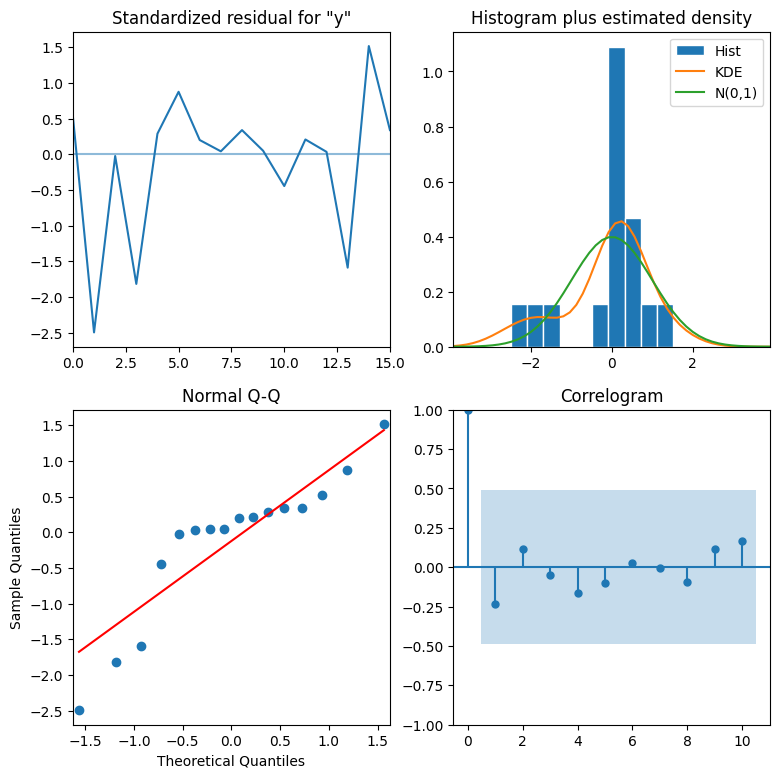

In [119]:
res.plot_diagnostics(figsize=(9,9))
plt.show()

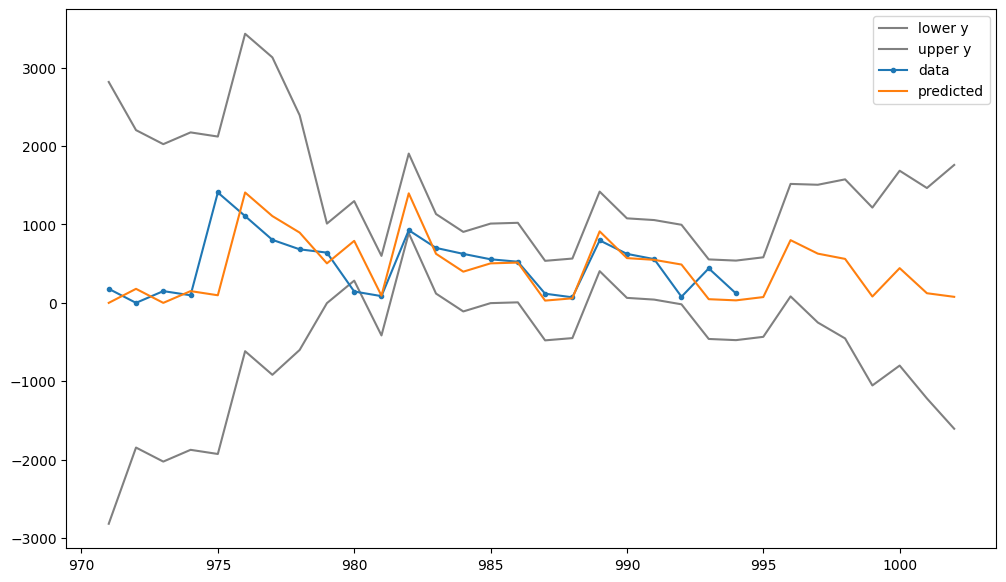

In [120]:
preds = res.get_prediction(end=len(df_cze_24d)+days_to_pred)
ci = preds.conf_int()

fig = ci.plot(color='grey', figsize=(12, 7))
res.data.orig_endog.plot(label='data', marker='.', fig=fig)
preds.predicted_mean.plot(label='predicted', fig=fig)
plt.legend()
plt.show()

Překvapivě tento model, který je statisticky horší, nejspíše z nedostatku dat, dává důvěryhodnější predikce.

#### Prophet

Prophet jako balíček nabízí nespočetné množství možností, které lze zakomponovat do samotného modelu. Nejlépe funguje na denních datech, což je idealní pro náš případ. Začneme od jednoduchého modelu a postupně budeme přibalovat. Prophet dokáže pracovat s několika sezónalitama najednou, tedy budeme používat celou historii dat.

Pro kompatibilitu je sloupec s datumy pojmenován jako `ds` a sloupec s incidencema jako `y`.

In [171]:
df_cze

,ds,y
0,2020-03-01,3.0
1,2020-03-02,0.0
2,2020-03-03,2.0
3,2020-03-04,3.0
4,2020-03-05,4.0
...,...,...
990,2022-11-16,625.0
991,2022-11-17,558.0
992,2022-11-18,78.0
993,2022-11-19,440.0


Základní model

14:04:31 - cmdstanpy - INFO - Chain [1] start processing
14:04:32 - cmdstanpy - INFO - Chain [1] done processing


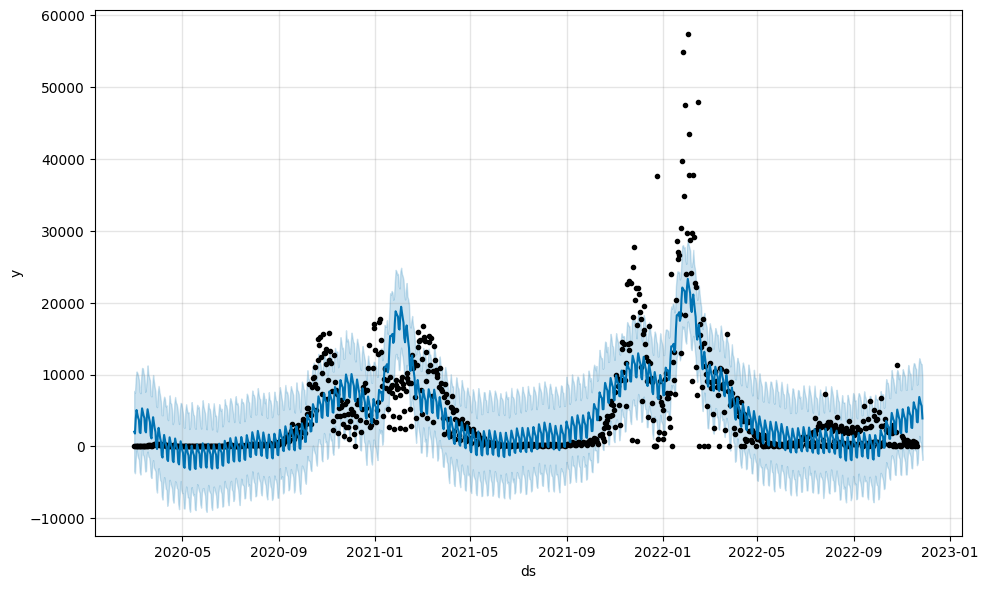

In [172]:
m = Prophet()                                   # Inicializace
m.fit(df_cze)                                   # Trénování
future = m.make_future_dataframe(periods=7)     # Vytvoření dataframe pro predikce
forecast = m.predict(future)                    # Predikování
m.plot(forecast).show()                         # Vyplotění výsledků

Jelikož není možné mít negativní počet nově nakažených je možné přidat sloupec `floor` k datům, zároveň se musí přidat sloupec `cap`, který určuje horní limit (nastavíme na největší současně dosaženou hodnotu), změnit model parametr `growth` na `logistic`.

14:08:51 - cmdstanpy - INFO - Chain [1] start processing
14:08:52 - cmdstanpy - INFO - Chain [1] done processing


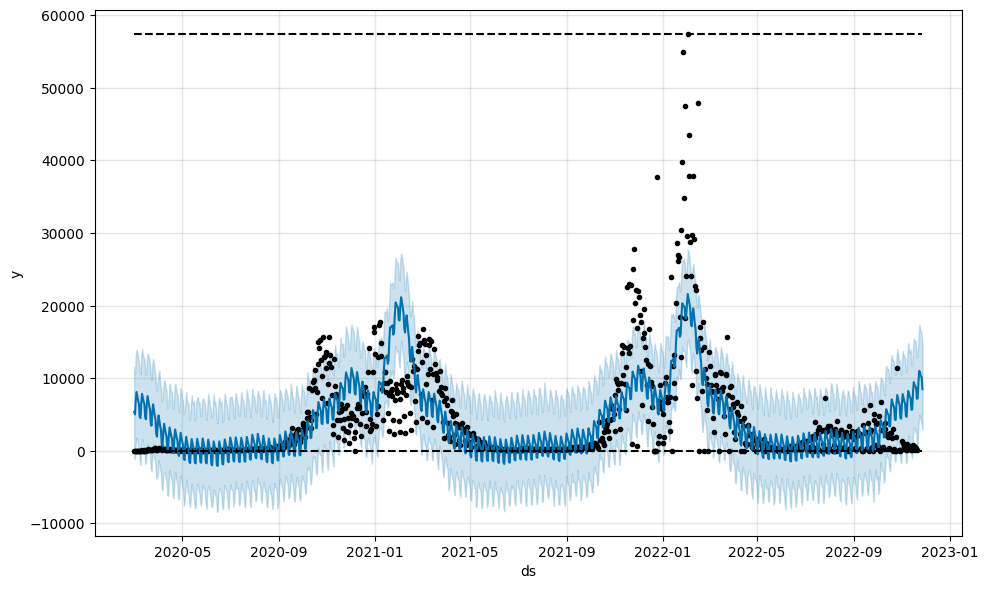

In [174]:
m = Prophet(growth='logistic')
df_cze['cap'] = df_cze['y'].max()
df_cze['floor'] = 0
m.fit(df_cze)
future = m.make_future_dataframe(periods=7)
future['cap'] = df_cze['y'].max()
future['floor'] = 0
forecast = m.predict(future)
m.plot(forecast).show()

Samotné komponenty pro předpověď můžeme vizualizovat pomocí `plot_components`.

[]

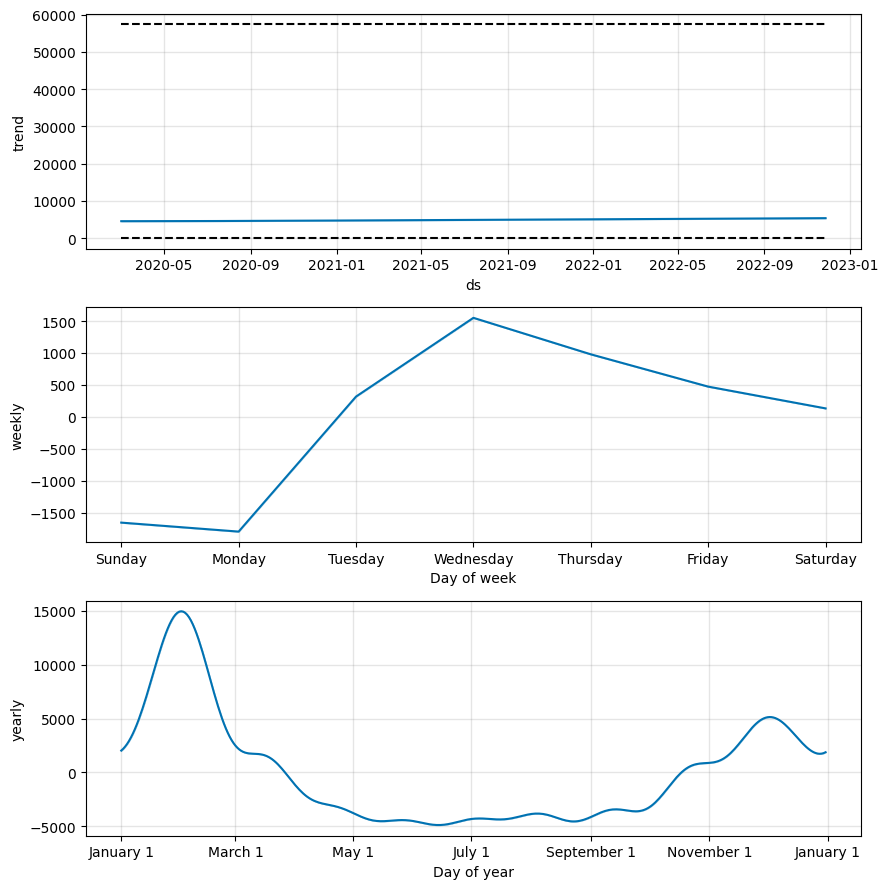

In [176]:
m.plot_components(forecast.drop(['floor', 'cap']))
plt.plot()

Dalšími parametry, které lze měnit, jsou `changepoint_prior_scale` a `seasonality_prior_scale`.

Reálné časové řady často obsahují velké změny v trendech. `Prophet` dokáže automaticky tato místa detekovat. Toto nastavení dokážeme upravit i ručně pomocí `changepoint_prior_scale`. Hodnoty budeme brát z logaritmické škály. (např. 0.01, 0.1, 1). Volnost v nastavení pro tyto custom trendy je větší. Více na https://facebook.github.io/prophet/docs/trend_changepoints.html.

`Prophet` dokáže k běžným sezónalitám, jako je měsiční, roční nebo týdenní, přidat další (např. státní svátky,). https://facebook.github.io/prophet/docs/seasonality,_holiday_effects,_and_regressors.html



14:39:01 - cmdstanpy - INFO - Chain [1] start processing
14:39:14 - cmdstanpy - INFO - Chain [1] done processing


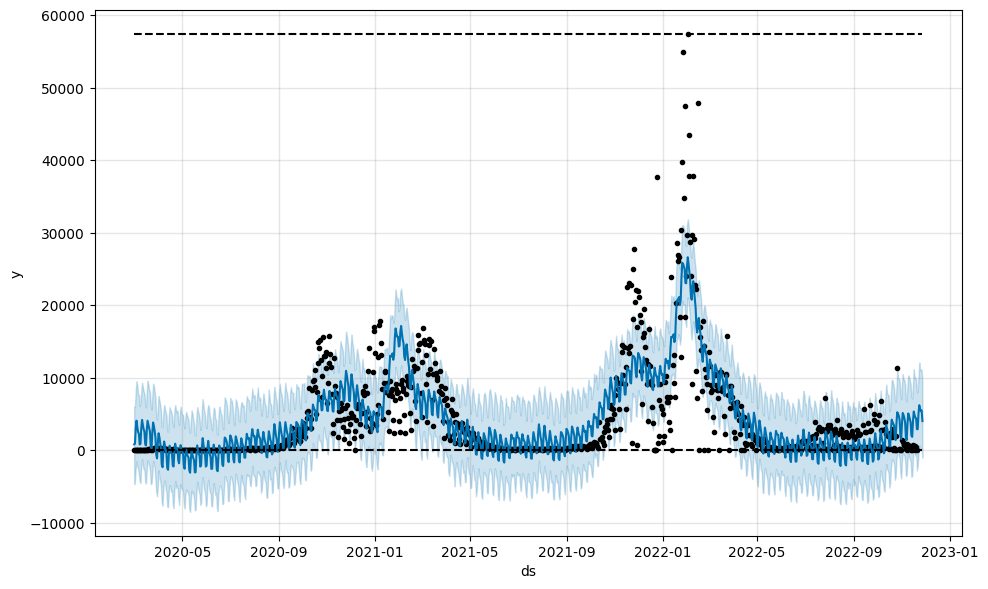

In [177]:
m = Prophet(growth='logistic',changepoint_prior_scale=1, seasonality_prior_scale=1)
m.add_seasonality(name='monthly', period=30.5, fourier_order=5)
df_cze['cap'] = df_cze['y'].max()
df_cze['floor'] = 0
m.fit(df_cze)
future = m.make_future_dataframe(periods=7)
future['cap'] = df_cze['y'].max()
future['floor'] = 0
forecast = m.predict(future)
m.plot(forecast).show()

[]

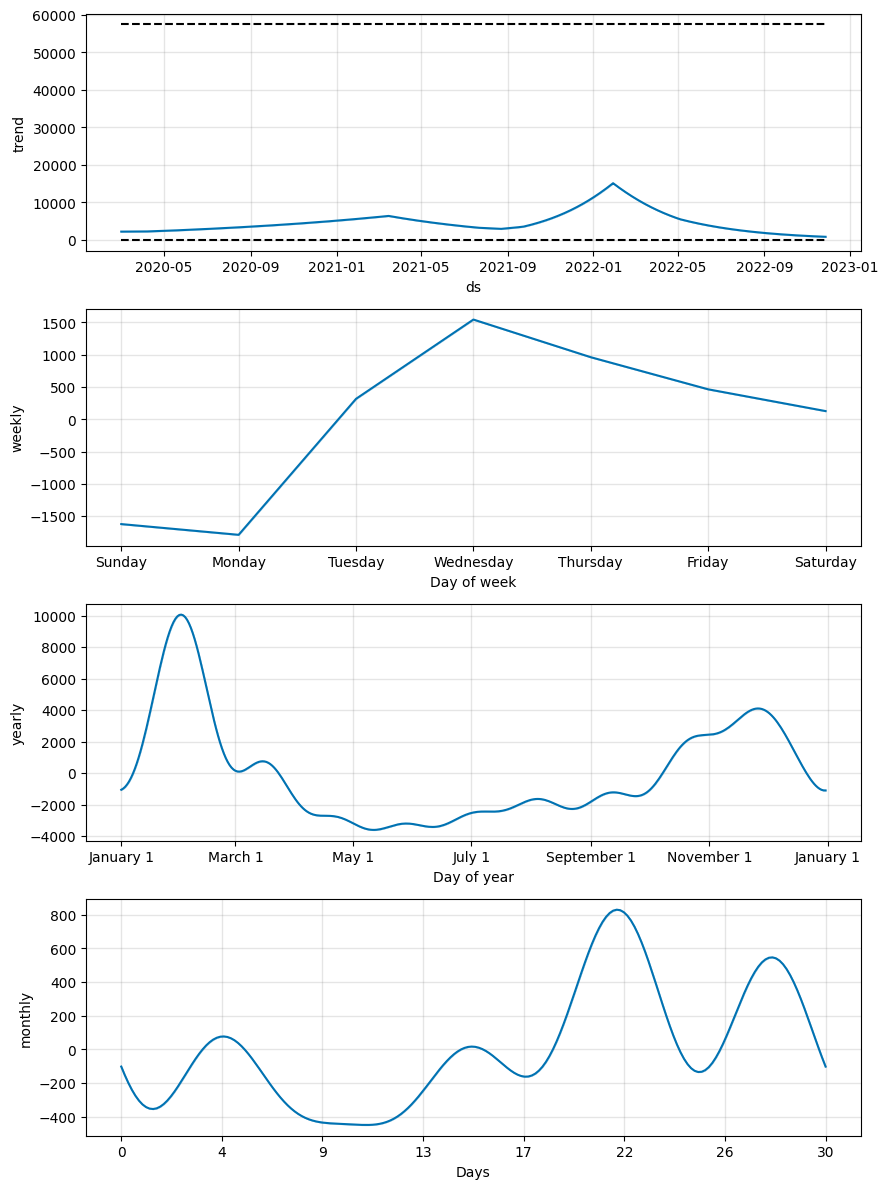

In [178]:
m.plot_components(forecast)
plt.plot()

Jako poslední zkusíme najít ideální parametry pro sézonnost a změny trendů.

In [184]:
# Code from https://facebook.github.io/prophet/docs/diagnostics.html#hyperparameter-tuning

import itertools
import numpy as np
import pandas as pd
from prophet.diagnostics import cross_validation, performance_metrics

param_grid = {  
    'changepoint_prior_scale': [0.01, 0.1, 1],
    'seasonality_prior_scale': [0.1, 1.0],
}

# Generate all combinations of parameters
all_params = [dict(zip(param_grid.keys(), v)) for v in itertools.product(*param_grid.values())]
rmses = []  # Store the RMSEs for each params here

cutoffs = pd.to_datetime(['2020-11-11', '2021-11-11', '2022-11-11'])

# Use cross validation to evaluate all parameters
for params in all_params:
    m = Prophet(**params)  # Fit model with given params
    m.add_seasonality(name='monthly', period=30.5, fourier_order=5)
    m.fit(df_cze)
    df_cv = cross_validation(m, cutoffs=cutoffs, horizon='7 days', parallel='processes')
    df_p = performance_metrics(df_cv, rolling_window=1)
    rmses.append(df_p['rmse'].values[0])

# Find the best parameters
tuning_results = pd.DataFrame(all_params)
tuning_results['rmse'] = rmses
print(tuning_results)

15:00:42 - cmdstanpy - INFO - Chain [1] start processing
15:00:44 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.
15:00:59 - cmdstanpy - INFO - Chain [1] start processing
15:01:00 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.
15:01:11 - cmdstanpy - INFO - Chain [1] start processing
15:01:12 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.
15:01:23 - cmdstanpy - INFO - Chain [1] start processing
15:01:24 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.
15:01:35 - cmdstanpy - INFO - Chain [1] start processing
15:01:41 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has per

   changepoint_prior_scale  seasonality_prior_scale         rmse
0                     0.01                      0.1  7567.444064
1                     0.01                      1.0  7590.092751
2                     0.10                      0.1  6662.357643
3                     0.10                      1.0  6628.748709
4                     1.00                      0.1  5764.182477
5                     1.00                      1.0  5345.974320


Pro `changepoint_prior_scale=1` a `seasonality_prior_scale=1` máme nejmenší `RMSE`. S těmito hodnotami natrénujeme model a podíváme se na výslednou predikci a rozložení do komponent.

15:03:51 - cmdstanpy - INFO - Chain [1] start processing
15:04:09 - cmdstanpy - INFO - Chain [1] done processing


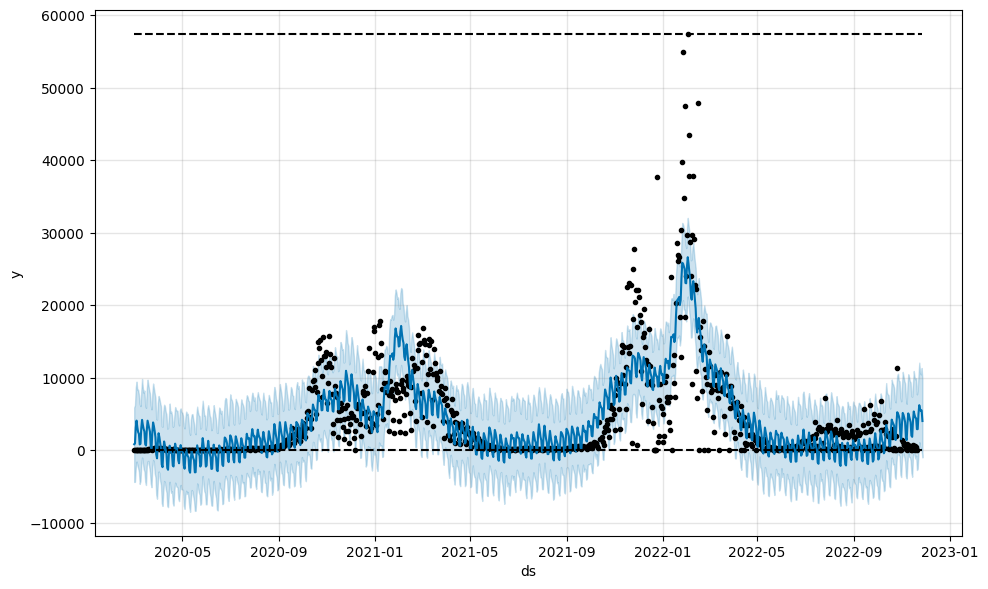

In [187]:
m = Prophet(growth='logistic',changepoint_prior_scale=1, seasonality_prior_scale=1)
m.add_seasonality(name='monthly', period=30.5, fourier_order=5)
df_cze['cap'] = df_cze['y'].max()
df_cze['floor'] = 0
m.fit(df_cze)
future = m.make_future_dataframe(periods=7)
future['cap'] = df_cze['y'].max()
future['floor'] = 0
forecast = m.predict(future)
m.plot(forecast).show()

[]

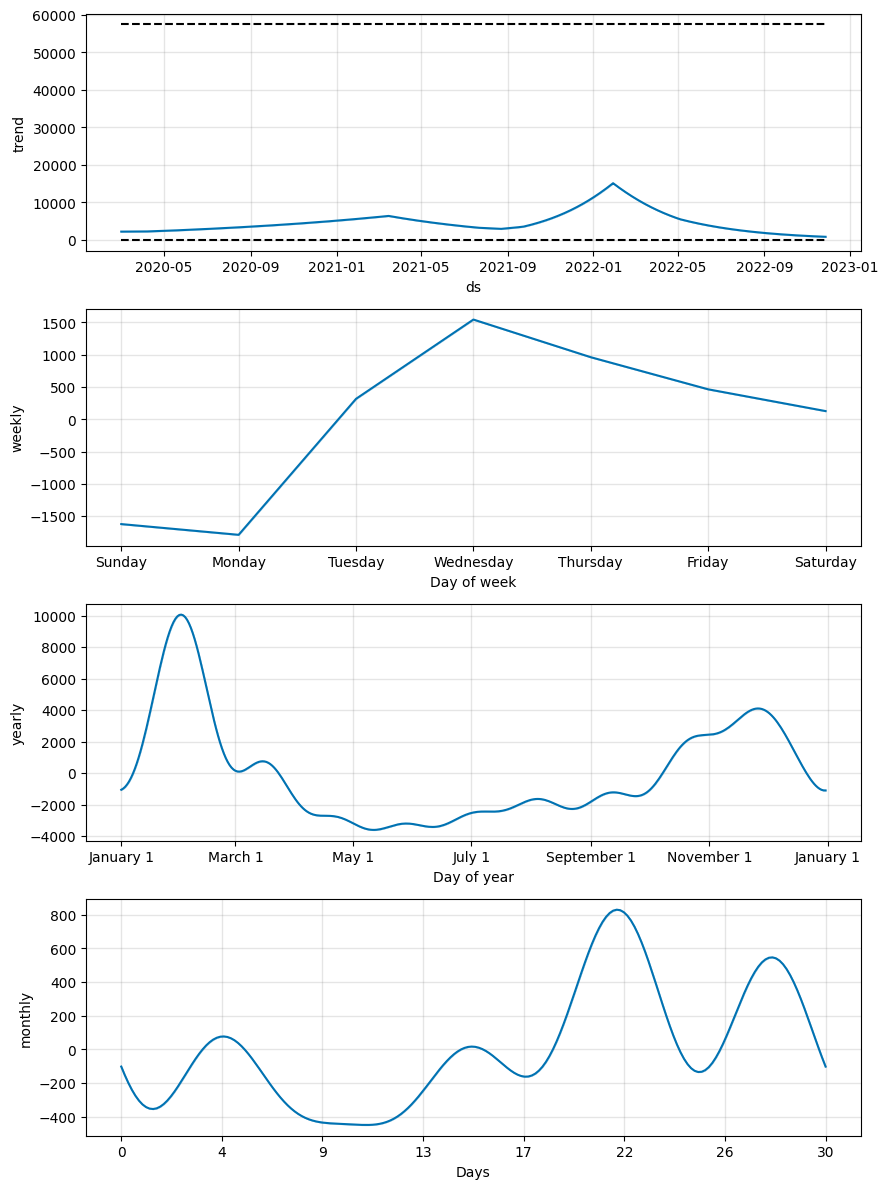

In [188]:
m.plot_components(forecast)
plt.plot()

Zajímavou sezónalitou je pravě ta měsiční, kde ke konci měsíce býva počet nově nakažených značně větší. Roční a týdenní sezónalita pro nás nejsou nijak překvapivé. Víme, že o víkendech se testuje mnohem méně lidí a že v chladnější měsících bývá více případů.

Určitě by šlo přidat mnohem více informací do daného modelu a Prophet to umožňuje, dokonce sami vývojáři mají vytvořenou stránku s ukázkou na COVID datech, kde přidávají například období lockdownů, pomocí, kterých vysvětlují náhle změny v trendech, atd. https://facebook.github.io/prophet/docs/handling_shocks.html#treating-covid-19-lockdowns-as-a-one-off-holidays